In [29]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import acovf
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error as MSE
import seaborn as sns
sns.set()

from matplotlib.pylab import rcParams
from sklearn.metrics import mean_squared_error

# Pré Processamento

In [32]:
data = pd.read_csv('airline.csv')
data = data.values

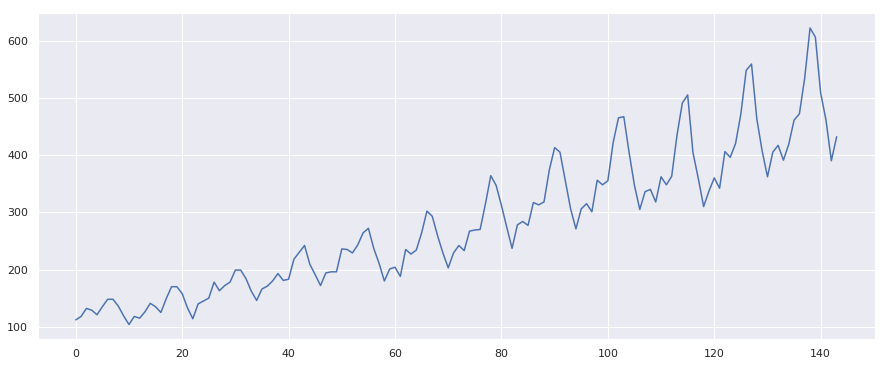

In [33]:
rcParams['figure.figsize'] = 15, 6
plt.plot(data)

In [19]:
def normalizar_serie(serie):
    minimo = min(serie)
    maximo = max(serie)
    y = (serie - minimo) / (maximo - minimo)
    return y

In [20]:
def desnormalizar(serie_atual, serie_real):
    minimo = min(serie_real)
    maximo = max(serie_real)
    
    serie = (serie_atual * (maximo - minimo)) + minimo
    
    return pd.DataFrame(serie)

In [16]:
def gerar_janelas(tam_janela, serie):
    # serie: vetor do tipo numpy ou lista
    tam_serie = len(serie)
    tam_janela = tam_janela +1 # Adicionado mais um ponto para retornar o target na janela
    
    janela = list(serie[0:0+tam_janela]) #primeira janela p criar o objeto np
    janelas_np = np.array(np.transpose(janela))    
       
    for i in range(1, tam_serie-tam_janela):  #começa do 1 
        janela = list(serie[i:i+tam_janela])
        j_np = np.array(np.transpose(janela))        
        
        janelas_np = np.vstack((janelas_np, j_np))
        
    
    return janelas_np

In [21]:
def select_lag_acf(serie, max_lag):
    from statsmodels.tsa.stattools import acf
    x = serie[0: max_lag+1]
    
    acf_x, confint = acf(serie, nlags=max_lag, alpha=.05, fft=False,
                             unbiased=False)
       
    limiar_superior = confint[:, 1] - acf_x
    limiar_inferior = confint[:, 0] - acf_x
    
    lags_selecionados = []
    
    for i in range(1, max_lag+1):

        
        if acf_x[i] >= limiar_superior[i] or acf_x[i] <= limiar_inferior[i]:
            lags_selecionados.append(i-1)  #-1 por conta que o lag 1 em python é o 0
    
    #caso nenhum lag seja selecionado, essa atividade de seleção para o gridsearch encontrar a melhor combinação de lags
    if len(lags_selecionados)==0:


        print('NENHUM LAG POR ACF')
        lags_selecionados = [i for i in range(max_lag)]

    print('LAGS', lags_selecionados)

    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
    #inverte o valor dos lags para usar na lista de dados se os dados forem de ordem [t t+1 t+2 t+3]
    lags_selecionados = [max_lag - (i+1) for i in lags_selecionados]
    #!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!

    return lags_selecionados

In [22]:
def split_serie_with_lags(serie, perc_train, perc_val = 0):
    
    #faz corte na serie com as janelas já formadas 
    
    x_date = serie[:, 0:-1]
    y_date = serie[:, -1]        
       
    train_size = np.fix(len(serie) *perc_train)
    train_size = train_size.astype(int)
    
    if perc_val > 0:        
        val_size = np.fix(len(serie) *perc_val).astype(int)
              
        
        x_train = x_date[0:train_size,:]
        y_train = y_date[0:train_size]
        print("Particao de Treinamento:", 0, train_size  )
        
        x_val = x_date[train_size:train_size+val_size,:]
        y_val = y_date[train_size:train_size+val_size]
        
        print("Particao de Validacao:",train_size, train_size+val_size)
        
        x_test = x_date[(train_size+val_size):-1,:]
        y_test = y_date[(train_size+val_size):-1]
        
        print("Particao de Teste:", train_size+val_size, len(y_date))
        
        return x_train, y_train, x_test, y_test, x_val, y_val
        
    else:
        
        x_train = x_date[0:train_size,:]
        y_train = y_date[0:train_size]

        x_test = x_date[train_size:-1,:]
        y_test = y_date[train_size:-1]

        return x_train, y_train, x_test, y_test

In [41]:
def treinar_mlp(x_train, y_train, x_val, y_val, num_exec, func_activation):
    
    
    neuronios =  [1, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
    alg_treinamento = ['lbfgs','adam']
    max_iteracoes = 10000
    learning_rate = ['adaptive', 'constant']
    qtd_lags_sel = len(x_train[0])
    best_result = np.Inf
    for i in range(0,len(neuronios)):
        for l in range(0,len(alg_treinamento)):
            for n in range(0,len(learning_rate)):
                for qtd_lag in range(1, len(x_train[0]+1)): #variando a qtd de pontos utilizados na janela 

                    print('QTD de Lags:', qtd_lag, 'Qtd de Neuronios' ,neuronios[i], 'Func. Act', func_activation[j])


                    for e in range(0,num_exec):
                        mlp = MLPRegressor(hidden_layer_sizes=neuronios[i], activation=func_activation, solver=alg_treinamento[l], max_iter = max_iteracoes, learning_rate= learning_rate[n])


                        mlp.fit(x_train[:,-qtd_lag:], y_train)
                        predict_validation = mlp.predict(x_val[:,-qtd_lag:])
                        mse = MSE(y_val, predict_validation)

                        if mse < best_result:
                            best_result = mse
                            print('Melhor MSE:', best_result)
                            select_model = mlp
                            qtd_lags_sel = qtd_lag


    return select_model, qtd_lags_sel

In [34]:
serie_normalizada = normalizar_serie(data)
janelas = gerar_janelas(20, serie_normalizada)
lags_acf = select_lag_acf(serie_normalizada, 20)

LAGS [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


In [35]:
x_train, y_train, x_test, y_test, x_val, y_val = split_serie_with_lags(janelas, 0.50, perc_val = 0.25)

Particao de Treinamento: 0 61
Particao de Validacao: 61 91
Particao de Teste: 91 123


In [ ]:
activation = ['relu', 'tanh']
for func in activation:
    results = np.zeros(30)
    for i in range(30):
        model, lag_sel = treinar_mlp(x_train, y_train, x_val, y_val, exec_modelo)
        predict_test = model.predict(x_test[:, -lag_sel:])
        results[i] = MSE(y_test, predict_test)
    print('Função de Ativação:', func, '- Média:', results.mean(), '- Std:', results.std(), '- Melhor MSE:', min(results))